# 의료 영상 진단👩‍⚕️
- 흉부 X-ray 이미지를 보고 폐렴을 진단하는 모델을 만들어본다.

## 학습목표
- 의료 영상의 기초 상식에 대해 알아본다
- 실제 의료 영상 데이터를 처리하는 실습을 진행한다

## 1.Set-up

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

- 데이터 셋

[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) :
중국 광저우 1~5세 소아 환자의 흉부 X선 영상

In [7]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("# of train:",len(train_filenames))
print("# of test:",len(test_filenames))
print("# of val:",len(val_filenames))

# of train: 5216
# of test: 624
# of val: 16


val 개수가 너무 적기때문에 train에서 val에 쓰일 데이터를 가져온다.
train과 val에 있는 데이터를 모은 다음에 train:val을 80:20으로 분할한다.

In [9]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인해본다.

In [11]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


In [12]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


결과를 보면 폐렴 이미지 수가 정상 이미지 보다 3배 가량 더 많이 있다. CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 학습이 더 잘되기 때문에 차후 불균형을 조정해야 한다.

tf.data 인스턴스를 생성한다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 효율적으로 할 수 있도록 해준다.

In [13]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [14]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


파일경로에 있는 'NORMAL'과 'PNEUMONIA'를 이용하여 라벨 데이터를 만들어준다.

In [15]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 사이즈를 통일시키고 gpu 메모리를 더욱 효율적으로 사용하기위해 이미지 사이즈를 줄여봅시다.

In [16]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 분리

In [17]:
# num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지 사이즈와, 라벨 확인

In [18]:
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


train, validation과 같은 방법으로 test 데이터 셋도 만들어준다.

In [19]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH) # tf.data 인스턴스를 생성
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.
아래 함수는 train 데이터 셋을 효율적으로 사용할 수 있도록 변환시켜 준다.

In [20]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # shuffle(): 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat(): epoch를 진행하면서 여러 번 데이터셋을 불러와 사용하게 해준다
    ds = ds.repeat()
    # BATCH_SIZE에서 정한 만큼의 배치
    ds = ds.batch(BATCH_SIZE)
    # prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에 리소스의 유휴 상태를 줄일 수 있다
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

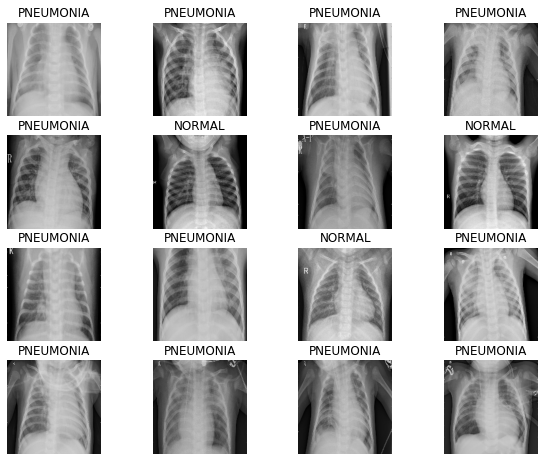

In [21]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

__Convolution Block 생성__
- Convolution을 두 번 진행하고
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
- Max Pooling

In [22]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

__Dense Block__

In [23]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Dense Block에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용된다.

 일반적으로 이런 방법은 잘 사용되지 않거나 금기시된다.
variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용되는것이 어울리지 않는다는 [논문](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)이 그 예이다.

그러나, 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 [경우](https://arxiv.org/pdf/1905.05928.pdf)도 있어,
이번 실습에서는 두가지를 함께 사용하는 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼 부분이다.

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

>__Weight balancing__<br>
training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. 

In [25]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [27]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 52s 135ms/step - loss: 0.5151 - accuracy: 0.7141 - precision: 0.9118 - recall: 0.6855 - val_loss: 0.6652 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 132ms/step - loss: 0.2733 - accuracy: 0.8979 - precision: 0.9697 - recall: 0.8910 - val_loss: 1.1092 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.2117 - accuracy: 0.9224 - precision: 0.9750 - recall: 0.9184 - val_loss: 0.0897 - val_accuracy: 0.9683 - val_precision: 0.9656 - val_recall: 0.9921
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1826 - accuracy: 0.9332 - precision: 0.9773 - recall: 0.9319 - val_loss: 0.1151 - val_accuracy: 0.9567 - val_precision: 0.9488 - val_recall: 0.9948
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1702 - accura

## 7. 결과 확인

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 76ms/step - loss: 0.6191 - accuracy: 0.8702 - precision: 0.8396 - recall: 0.9795
Loss: 0.6190516948699951,
Accuracy: 0.870192289352417,
Precision: 0.8395604491233826,
Recall: 0.9794871807098389


In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.6191 - accuracy: 0.8702 - precision: 0.8396 - recall: 0.9795
Loss: 0.6190515756607056,
Accuracy: 0.870192289352417,
Precision: 0.8395604491233826,
Recall: 0.9794871807098389
